In [1]:
import numpy as np
import tensorflow as tf
from glob import glob
from typing import List,Dict
from fnmatch import fnmatch
import matplotlib.pyplot as plt
import re
import os
print(tf.__version__)

2.3.0


In [3]:

# function to contruct back from tf record example
def prepare_sample(example):
    example["grid_map"] = tf.io.decode_raw(example["grid_map"], out_type=tf.float16)
    example["grid_map"] = tf.reshape(example["grid_map"],[1536,1536])

    example["grid_org_res"] = tf.io.decode_raw(example["grid_org_res"], out_type=tf.float32)
    #example["grid_org_res"] = tf.reshape(example["grid_org_res"],[1,3])

    example["left_bnd"] = tf.io.decode_raw(example["left_bnd"], out_type=tf.float32)
    example["left_bnd"] = tf.reshape(example["left_bnd"],[25,2])

    example["right_bnd"] = tf.io.decode_raw(example["right_bnd"], out_type=tf.float32)
    example["right_bnd"] = tf.reshape(example["right_bnd"],[25,2])

    example["car_odo"] = tf.io.decode_raw(example["car_odo"], out_type=tf.float32)
    #example["car_odo"] = tf.reshape(example["car_odo"],[1,3])

    example["init_path"] = tf.io.decode_raw(example["init_path"], out_type=tf.float32)
    example["init_path"] = tf.reshape(example["init_path"],[25,2])

    example["opt_path"] = tf.io.decode_raw(example["opt_path"], out_type=tf.float32)
    example["opt_path"] = tf.reshape(example["opt_path"],[25,2])
    return example


def parse_tfrecord_fn_ds(example):

    # Dict of feature and their description
    feature_description = {

        # model inputs
        "grid_map": tf.io.FixedLenFeature([], tf.string),
        "grid_org_res": tf.io.FixedLenFeature([], tf.string),
        "left_bnd": tf.io.FixedLenFeature([], tf.string),
        "right_bnd": tf.io.FixedLenFeature([], tf.string),
        "car_odo": tf.io.FixedLenFeature([], tf.string),
        "init_path": tf.io.FixedLenFeature([], tf.string),
        
        #model ouput
        "opt_path": tf.io.FixedLenFeature([], tf.string),

    }

    # Parse a single Example proto
    example = tf.io.parse_single_example(example, feature_description)
    return example

In [8]:
tfrecords_path = '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_costmap_dist_dir/scenario_ph_15/2021-07-22_16-16-14/2021-07-22_16-16-15_0_file_01-16.tfrec'
sample_raw_ds = tf.data.TFRecordDataset(tfrecords_path)

parsed_dataset = sample_raw_ds.map(parse_tfrecord_fn_ds).map(prepare_sample)

parsed_dataset.element_spec


{'car_odo': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'grid_map': TensorSpec(shape=(1536, 1536), dtype=tf.float16, name=None),
 'grid_org_res': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'init_path': TensorSpec(shape=(25, 2), dtype=tf.float32, name=None),
 'left_bnd': TensorSpec(shape=(25, 2), dtype=tf.float32, name=None),
 'opt_path': TensorSpec(shape=(25, 2), dtype=tf.float32, name=None),
 'right_bnd': TensorSpec(shape=(25, 2), dtype=tf.float32, name=None)}

In [13]:
def plot_scene(features):    
    grid_map = features["grid_map"].numpy()
    grid_org = features["grid_org_res"].numpy()
    left_bnd = features["left_bnd"].numpy()
    right_bnd = features["right_bnd"].numpy()
    init_path = features["init_path"].numpy()
    opt_path = features["opt_path"].numpy()
    car_odo = features["car_odo"].numpy()

    #print(type(grid_map))
    plt.figure(figsize=(7, 7))
    #ax=fig.add_subplot(1,1,1)

    res = grid_org[2]
    plt.plot((left_bnd[:,0]-grid_org[0])/res,(left_bnd[:,1]-grid_org[1])/res,'-.', color='magenta',markersize=0.5, linewidth=0.5)

    plt.plot((init_path[:,0]-grid_org[0])/res,(init_path[:,1]-grid_org[1])/res,'o-', color='lawngreen',markersize=1, linewidth=1)
    plt.plot((opt_path[:,0]-grid_org[0])/res,(opt_path[:,1]-grid_org[1])/res,'--', color='yellow',markersize=1, linewidth=1)

    plt.plot((right_bnd[:,0]-grid_org[0])/res,(right_bnd[:,1]-grid_org[1])/res, '-.',color='magenta',markersize=0.5, linewidth=0.5)


    plt.plot((car_odo[0]-grid_org[0])/res,(car_odo[1]-grid_org[1])/res,'r*', color = 'red',markersize=8)


    plt.legend(['Left bound', 'gt_init_path', 'gt_opt_path','right bound', 'car_centre'], loc='lower left')

    plt.imshow(grid_map.astype(float),origin="lower",cmap='jet')

    return plt

car_odo: (3,)
grid_map: (1536, 1536)
grid_map: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
grid_org_res: (3,)
init_path: (25, 2)
left_bnd: (25, 2)
opt_path: (25, 2)
right_bnd: (25, 2)


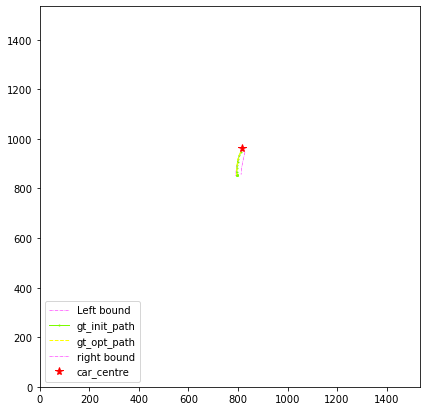

In [17]:
for features in parsed_dataset.skip(10).take(1):
    for key in features.keys():
        #if key != "grid_map":
        print(f"{key}: {np.shape(features[key].numpy())}")
        if key == "grid_map":
            print(f"{key}: {features[key].numpy()}")

    _ = plot_scene(features=features)